In [5]:
techmeme_rss = "https://www.techmeme.com/feed.xml"


In [54]:
import requests
import xml.etree.ElementTree as ET
from datetime import datetime
from bs4 import BeautifulSoup
import warnings
import urllib3
import os
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain.schema import Document
import os
from dotenv import load_dotenv

def parse_techmeme_rss():
    try:
        response = requests.get("https://www.techmeme.com/feed.xml")
        root = ET.fromstring(response.content)
        
        articles = []
        for item in root.findall('.//item'):
            title = item.find('title').text if item.find('title') is not None else "No title"
            link = item.find('link').text if item.find('link') is not None else "No link"
            description = item.find('description').text if item.find('description') is not None else "No description"
            pub_date = item.find('pubDate').text if item.find('pubDate') is not None else "No date"
            
            articles.append({
                'title': title,
                'link': link,
                'description': description,
                'pub_date': pub_date
            })
        
        return articles
    
    except Exception as e:
        print(f"Error parsing RSS: {e}")
        return []

In [23]:
articles = parse_techmeme_rss()
print(f"Successfully parsed {len(articles)} articles from Techmeme RSS feed")

Successfully parsed 15 articles from Techmeme RSS feed


In [30]:
articles[0]['description']

'<A HREF="https://www.cnbc.com/2025/09/30/scorability-wants-to-revolutionize-college-sports-recruiting-as-nil-takes-off.html"><IMG VSPACE="4" HSPACE="4" BORDER="0" ALIGN="RIGHT" SRC="http://www.techmeme.com/251005/i20.jpg"></A>\n<P><A HREF="http://www.techmeme.com/251005/p20#a251005p20" TITLE="Techmeme permalink"><IMG WIDTH=11 HEIGHT=12 SRC="http://www.techmeme.com/img/pml.png" STYLE="border:none;padding:0;margin:0;"></A> Jessica Golden / <A HREF="http://www.cnbc.com/">CNBC</A>:<BR>\n<SPAN STYLE="font-size:1.3em;"><B><A HREF="https://www.cnbc.com/2025/09/30/scorability-wants-to-revolutionize-college-sports-recruiting-as-nil-takes-off.html">Scorability, a college sports recruiting marketplace for athletes and coaches, raised $40M led by Bluestone Equity Partners, bringing its total funding to $51M</A></B></SPAN>&nbsp; &mdash;&nbsp; Sports tech platform Scorability has raised $40 million in fresh funding as the company looks to modernize college sports recruiting, the company announced o

In [31]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(articles[0]['description'], "html.parser")
text = soup.get_text()
text

'\n Jessica Golden / CNBC:\nScorability, a college sports recruiting marketplace for athletes and coaches, raised $40M led by Bluestone Equity Partners, bringing its total funding to $51M\xa0 —\xa0 Sports tech platform Scorability has raised $40 million in fresh funding as the company looks to modernize college sports recruiting, the company announced on Tuesday.\n'

In [41]:
def get_text():
    articles = parse_techmeme_rss()
    for i in range(len(articles)):
        soup = BeautifulSoup(articles[i]['description'], "html.parser")
        text = soup.get_text()
        articles[i]['description'] = text
    return articles

In [44]:
get_text()[0]

{'title': 'Scorability, a college sports recruiting marketplace for athletes and coaches, raised $40M led by Bluestone Equity Partners, bringing its total funding to $51M (Jessica Golden/CNBC)',
 'link': 'http://www.techmeme.com/251005/p20#a251005p20',
 'description': '\n Jessica Golden / CNBC:\nScorability, a college sports recruiting marketplace for athletes and coaches, raised $40M led by Bluestone Equity Partners, bringing its total funding to $51M\xa0 —\xa0 Sports tech platform Scorability has raised $40 million in fresh funding as the company looks to modernize college sports recruiting, the company announced on Tuesday.\n',
 'pub_date': 'Sun, 05 Oct 2025 18:30:01 -0400'}

In [ ]:
load_dotenv()
openai_api_key = os.environ["OPENAI_API_KEY"]
embedding_model = OpenAIEmbeddings(api_key=openai_api_key, model="text-embedding-3-small")

def Embedding_news():
    articles = get_text()
    splitter = RecursiveCharacterTextSplitter(
        separators=["\n\n", "\n", " ", ""],
        chunk_size=100,
        chunk_overlap=10
    )

    all_docs = []

    for article in articles:
        news_content = f"Title: {article['title']}, Content: {article['description']}"
        chunks = splitter.split_text(news_content)

        doc_objs = [
            Document(
                page_content=chunk,
                metadata={
                    "title": article["title"],
                    "link": article["link"],
                    "pub_date": article["pub_date"]
                }
            )
            for chunk in chunks
        ]

        all_docs.extend(doc_objs)

    vector_store = Chroma.from_documents(
        documents=all_docs,
        embedding=embedding_model
    )

    return vector_store

In [56]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper


wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
wikipedia.run('burn the witch')

/Users/kensukeumamoshi/miniconda3/lib/python3.13/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /Users/kensukeumamoshi/miniconda3/lib/python3.13/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


'Page: Burn the Witch (manga)\nSummary: Burn the Witch (stylized as BURN ☩HE WITCH) is a Japanese manga series written and illustrated by Tite Kubo. It was first published in Shueisha\'s Weekly Shōnen Jump as a one-shot chapter in July 2018. A serialized continuation of the one-shot is being published in the same magazine with a seasonal release schedule. The four-chapter first season was published from August to September 2020. A second season of the manga has been announced. The series\' title comes from a 2016 song by the English band Radiohead.\nAn anime film produced by Studio Colorido premiered in October 2020. A television film adaptation of the prologue chapter, Burn the Witch #0.8, premiered in December 2023.\n\n\n\nPage: Burn the Witch (Radiohead song)\nSummary: "Burn the Witch" is a song by the English rock band Radiohead, released as the lead single from their ninth studio album, A Moon Shaped Pool (2016). It features a string section playing with guitar plectrums, producin

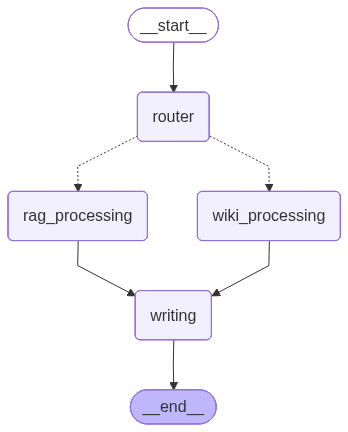

✅ LangGraph visualization generated successfully!


In [4]:
# LangGraph Built-in Visualization
# This uses the actual graph object from your graph.py file

from graph import app
from IPython.display import Image, display

# Display the LangGraph diagram using the built-in visualization
try:
    # Get the graph visualization
    graph_image = app.get_graph().draw_mermaid_png()
    display(Image(graph_image))
    print("✅ LangGraph visualization generated successfully!")
except Exception as e:
    print(f"❌ Error generating graph diagram: {e}")
    print("Make sure you have the required dependencies installed:")
    print("pip install langgraph")